In [10]:
import json
import pandas as pd


In [11]:
with open('../intents.json') as f:
    data = json.load(f)
data 

{'intents': [{'tag': 'greeting',
   'patterns': ['Hi',
    'Hey',
    'Is anyone there?',
    'Hi there',
    'Hello',
    'Hey there',
    'Howdy',
    'Hola',
    'Bonjour',
    'Konnichiwa',
    'Guten tag',
    'Ola'],
   'responses': ['Hello there. Tell me how are you feeling today?',
    'Hi there. What brings you here today?',
    'Hi there. How are you feeling today?',
    'Great to see you. How do you feel currently?',
    "Hello there. Glad to see you're back. What's going on in your world right now?"]},
  {'tag': 'morning',
   'patterns': ['Good morning'],
   'responses': ["Good morning. I hope you had a good night's sleep. How are you feeling today? "]},
  {'tag': 'afternoon',
   'patterns': ['Good afternoon'],
   'responses': ['Good afternoon. How is your day going?']},
  {'tag': 'evening',
   'patterns': ['Good evening'],
   'responses': ['Good evening. How has your day been?']},
  {'tag': 'night',
   'patterns': ['Good night'],
   'responses': ['Good night. Get some prop

In [12]:
# Flattening the dataset for EDA and modelling
dic = {'tags':[], 'patterns':[], 'responses':[]}

for example in data['intents']:
   
    for pattern in example['patterns']:
        dic['tags'].append(example['tag'])
        dic['patterns'].append(pattern)
        dic['responses'].append(example['responses'])
dic


{'tags': ['greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'morning',
  'afternoon',
  'evening',
  'night',
  'goodbye',
  'goodbye',
  'goodbye',
  'goodbye',
  'goodbye',
  'goodbye',
  'goodbye',
  'goodbye',
  'thanks',
  'thanks',
  'thanks',
  'thanks',
  'thanks',
  'no-response',
  'neutral-response',
  'about',
  'about',
  'about',
  'about',
  'about',
  'about',
  'about',
  'about',
  'skill',
  'creation',
  'creation',
  'creation',
  'name',
  'name',
  'name',
  'help',
  'help',
  'help',
  'help',
  'help',
  'help',
  'help',
  'sad',
  'sad',
  'sad',
  'sad',
  'sad',
  'sad',
  'sad',
  'sad',
  'stressed',
  'stressed',
  'stressed',
  'stressed',
  'stressed',
  'worthless',
  'worthless',
  'worthless',
  'worthless',
  'worthless',
  'depressed',
  'depressed',
  'depressed',
  'depressed',
  'happy',
  'happy',
  'happy',
  'happy',
  'happ

In [13]:
df = pd.DataFrame.from_dict(dic)
df

,tags,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...
...,...,...,...
227,fact-29,How do I know if I'm unwell?,"[If your beliefs , thoughts , feelings or beha..."
228,fact-30,How can I maintain social connections? What if...,"[A lot of people are alone right now, but we d..."
229,fact-31,What's the difference between anxiety and stress?,[Stress and anxiety are often used interchange...
230,fact-32,What's the difference between sadness and depr...,"[Sadness is a normal reaction to a loss, disap..."


In [14]:
df['tags'].value_counts()

tags
greeting    12
casual      11
sad          8
goodbye      8
default      8
            ..
fact-25      1
fact-28      1
fact-29      1
fact-30      1
fact-31      1
Name: count, Length: 80, dtype: int64

In [15]:
df

,tags,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...
...,...,...,...
227,fact-29,How do I know if I'm unwell?,"[If your beliefs , thoughts , feelings or beha..."
228,fact-30,How can I maintain social connections? What if...,"[A lot of people are alone right now, but we d..."
229,fact-31,What's the difference between anxiety and stress?,[Stress and anxiety are often used interchange...
230,fact-32,What's the difference between sadness and depr...,"[Sadness is a normal reaction to a loss, disap..."


In [16]:
df['tags']

0      greeting
1      greeting
2      greeting
3      greeting
4      greeting
         ...   
227     fact-29
228     fact-30
229     fact-31
230     fact-32
231     fact-32
Name: tags, Length: 232, dtype: object

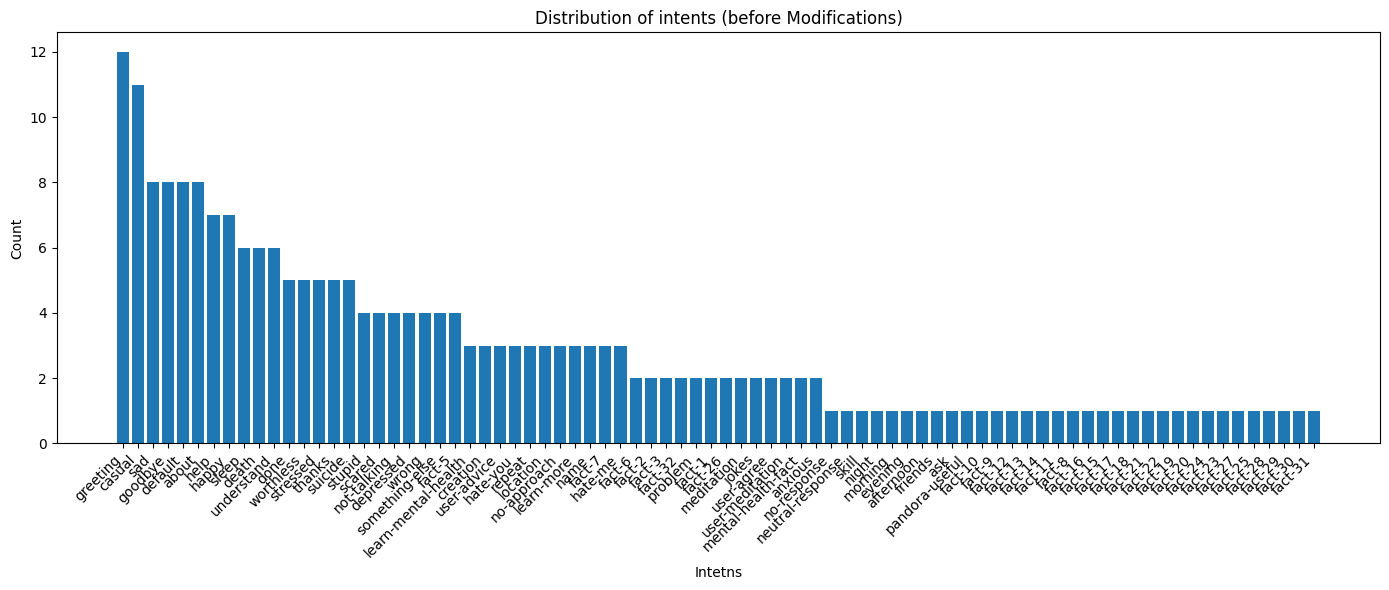

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))

plt.bar(df['tags'].value_counts().index,df['tags'].value_counts().values)

plt.title('Distribution of intents (before Modifications)')
plt.xlabel('Intetns')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [22]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from torch.cuda.amp import autocast
import torch
import logging
import json
import re

# Initialize the model and tokenizer
model_name = "tuner007/pegasus_paraphrase"
model = PegasusForConditionalGeneration.from_pretrained(model_name).to('cuda')
tokenizer = PegasusTokenizer.from_pretrained(model_name)

# Enable logging
logging.basicConfig(level=logging.INFO)

def paraphrase_with_pegasus(text, num_return_sequences=3, num_beams=10):
    """ Generate multiple paraphrases from Pegasus model. """
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")

    with autocast():
        outputs = model.generate(
            input_ids["input_ids"],
            attention_mask=input_ids["attention_mask"],
            max_length=80,
            num_beams=num_beams,
            num_return_sequences=num_return_sequences,
            no_repeat_ngram_size=2,
            early_stopping=True
        )

    return tokenizer.batch_decode(outputs, skip_special_tokens=True)  # Return multiple paraphrases

def is_valid_pattern(new_pattern, unique_patterns):
    """ Check if the new pattern is valid (not just case or punctuation change). """
    new_pattern_normalized = re.sub(r'[^\w\s]', '', new_pattern.lower())
    for pattern in unique_patterns:
        pattern_normalized = re.sub(r'[^\w\s]', '', pattern.lower())
        if new_pattern_normalized == pattern_normalized:
            return False
    return True

def augment_patterns(tags_patterns, target_count=12):
    """ Generate paraphrases efficiently until each tag has at least 12 unique patterns. """
    augmented_patterns = {}

    for tag, patterns in tags_patterns.items():
        logging.info(f"Starting augmentation for tag: {tag}")

        unique_patterns = set(patterns)
        pattern_queue = list(unique_patterns)  

        while len(unique_patterns) < target_count:
            if not pattern_queue:
                break  # No more patterns to process
            
            current_pattern = pattern_queue.pop(0)  # Get next pattern
            
            # Generate multiple new patterns at once
            new_patterns = paraphrase_with_pegasus(current_pattern, num_return_sequences=3)

            for new_pattern in new_patterns:
                new_pattern = new_pattern.strip().lower()

                if len(unique_patterns) >= target_count:
                    break  # Stop if we already reached 12 patterns

                if is_valid_pattern(new_pattern, unique_patterns):
                    unique_patterns.add(new_pattern)
                    pattern_queue.append(new_pattern)  # Add new pattern for further paraphrasing

            logging.info(f"Tag: {tag} | Unique patterns: {len(unique_patterns)}/{target_count}")

        augmented_patterns[tag] = list(unique_patterns)[:target_count]  # Ensure exactly 12 patterns

        logging.info(f"Completed augmentation for tag: {tag} | Total patterns: {len(unique_patterns)}")

    return augmented_patterns

# Load the original JSON data
with open('intents.json', 'r') as f:
    original_data = json.load(f)

# Extract tags and patterns
tags_patterns = {intent['tag']: intent['patterns'] for intent in original_data['intents']}

# Augment patterns
augmented_patterns = augment_patterns(tags_patterns)

# Update the original data with augmented patterns
for intent in original_data['intents']:
    tag = intent['tag']
    if tag in augmented_patterns:
        intent['patterns'] = augmented_patterns[tag]

# Save the updated data back to the JSON file
with open('pegasus_data_4.json', 'w') as f:
    json.dump(original_data, f, indent=4)

logging.info("Augmentation completed and data saved to 'pegasus_data_updated.json'")


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Starting augmentation for tag: greeting
INFO:root:Completed augmentation for tag: greeting | Total patterns: 12
INFO:root:Starting augmentation for tag: morning
C:\Users\seleem\AppData\Local\Temp\ipykernel_516\3367723861.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
INFO:root:Tag: morning | Unique patterns: 2/12
INFO:root:Tag: morning | Unique patterns: 4/12
INFO:root:Tag: morning | Unique patterns: 7/12
INFO:root:Tag: morning | Unique patterns: 9/12
INFO:root:Tag: morning | Unique patterns: 11/12
INFO:root:Tag: morning | Unique pattern

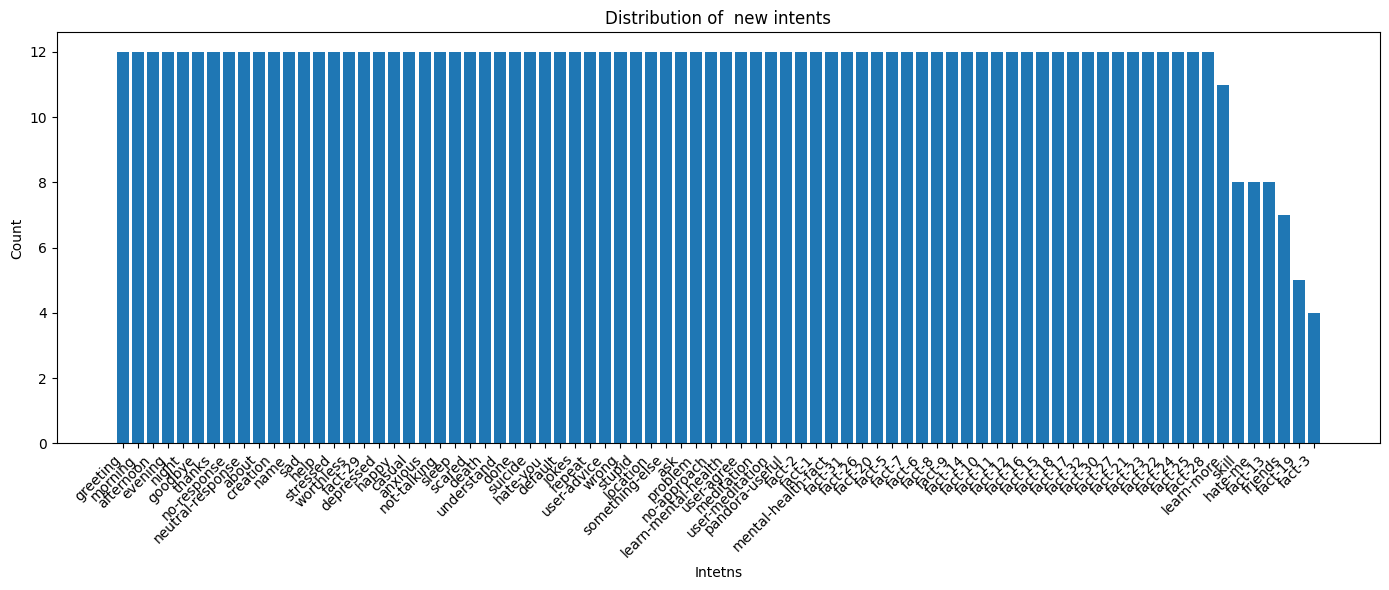

In [23]:
with open ('pegasus_data_4.json') as f:
    data2 = json.load(f)
# Flattening the dataset for EDA and modelling
dic2 = {'tags':[], 'patterns':[], 'responses':[]}

for example in data2['intents']:
   
    for pattern in example['patterns']:
        dic2['tags'].append(example['tag'])
        dic2['patterns'].append(pattern)
        dic2['responses'].append(example['responses'])
df2 = pd.DataFrame.from_dict(dic2)

plt.figure(figsize=(14,6))

plt.bar(df2['tags'].value_counts().index,df2['tags'].value_counts().values)

plt.title('Distribution of  new intents')
plt.xlabel('Intetns')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()